In [1]:
import os
import numpy as np
import pandas as pd
pd.set_option('display.expand_frame_repr', False)
import gspread
import matplotlib.pyplot as plt

In [13]:
exps = ['0927_jiuhai_seed-01']

datasets = ['ogb-molpcba', 'ogb-molhiv', 'ogbg-ppa', 'UPFD', 'SBM-Isolation', 'SBM-Environment', 'RotatedMNIST', 'ColoredMNIST']
algorithms = ['ERM', 'groupDRO', 'IRM', 'deepCORAL', 'DANN', 'DANN-G', 'MLDG', 'FLAG']
models = ['gin', 'mlp', 'gin_10_layers', 'gcn', 'gin_virtual', 'transformer', 'cheb', '3wlgnn']


def parse_performance(d, a, m, exps, assert_length=True):
    epoches_coeff = 1
    performances = []
    for exp in exps:
        seeds = [0, 1]
        for seed in seeds:
            test_eval = pd.read_csv(f'./logs/{exp}/{d}_{a}_{m}_seed-{seed}_test_eval.csv', sep=',')
            test_eval = test_eval.dropna(axis=0)
            test_eval = test_eval.iloc[:,1].to_numpy()
            val_eval = pd.read_csv(f'./logs/{exp}/{d}_{a}_{m}_seed-{seed}_val_eval.csv', sep=',')
            val_eval = val_eval.dropna(axis=0)
            val_eval = val_eval.iloc[:,1].to_numpy()
            train_eval = pd.read_csv(f'./logs/{exp}/{d}_{a}_{m}_seed-{seed}_train_eval.csv', sep=',')
            train_eval = train_eval.dropna(axis=0)
            train_eval = train_eval.iloc[:,1].to_numpy()
            nepoch = max([len(train_eval), len(val_eval), len(test_eval)])
            performances.append((train_eval[:nepoch], val_eval[:nepoch], test_eval[:nepoch]))
    return performances
    
def filter_test_performance(performances):
    results = []
    for per in performances:
        train_eval, val_eval, test_eval = per
        results.append(test_eval[np.argmax(val_eval)])
    return results


def filter_performance_gaps(performances):
    results = []
    for per in performances:
        train_eval, val_eval, test_eval = per
        results.append((train_eval[np.argmax(val_eval)]-test_eval[np.argmax(val_eval)]))
    return results

def filter_num_epoches(performances):
    results = []
    for per in performances:
        train_eval, val_eval, test_eval = per
        results.append(len(train_eval))
    return results

def filter_uncertainty(results):
    results = np.array(results)
    if len(results) == 1:
        return f'{results[0]:.3f}±?'
    return f'{np.mean(results):.3f}±{np.std(results):.3f}'


def filter_plot(performances):
    results = []
    plt.figure(figsize=(10, 5))
    for per in performances:
        train_eval, val_eval, test_eval = per
        plt.plot(train_eval, 'r')
        plt.plot(val_eval, 'g')
        plt.plot(test_eval, 'b')
    plt.show()
    return results


def parse(mode, **kwargs):
    try:
        if mode == 'test_performance':
            return filter_uncertainty(filter_test_performance(parse_performance(**kwargs)))
        if mode == 'performance_gap':
            return filter_uncertainty(filter_performance_gaps(parse_performance(**kwargs)))
        if mode == 'num_epoches':
            return filter_uncertainty(filter_num_epoches(parse_performance(**kwargs)))
        if mode == 'convergence_plot':
            return filter_plot(parse_performance(**kwargs))
        else:
            raise NotImplementError
    except OSError as e:
        return 'fnf'
    except pd.errors.EmptyDataError as e:
        return 'err'

In [14]:
table = []
m = models[0]
for i, d in enumerate(datasets):
    table_dataset = []
    for j, a in enumerate(algorithms):
        table_dataset.append(parse('test_performance', d=d, a=a, m=m, exps=exps))
    table.append(table_dataset)
    
table = pd.DataFrame(table, index=datasets, columns=algorithms)

print(table)
#print(table.to_csv(index=False, header=False))

                         ERM     groupDRO          IRM    deepCORAL         DANN       DANN-G         MLDG         FLAG
ogb-molpcba      0.156±0.019  0.154±0.006  0.045±0.002  0.054±0.001          err          err          err  0.171±0.010
ogb-molhiv       0.763±0.009  0.729±0.008  0.701±0.010  0.695±0.014          err          err  0.615±0.025  0.747±0.002
ogbg-ppa         0.581±0.001  0.348±0.199  0.299±0.025  0.526±0.039          err          err  0.103±0.003  0.601±0.009
UPFD             0.628±0.001  0.639±0.003  0.618±0.017  0.642±0.004  0.637±0.000  0.636±0.006  0.639±0.003  0.639±0.007
SBM-Isolation    0.616±0.001  0.599±0.007  0.604±0.004  0.609±0.010  0.579±0.012  0.591±0.007  0.609±0.017  0.610±0.006
SBM-Environment  0.772±0.004  0.757±0.004  0.749±0.005  0.771±0.005  0.730±0.006  0.731±0.005  0.731±0.005  0.755±0.001
RotatedMNIST     0.511±0.003  0.504±0.001  0.513±0.007  0.515±0.003  0.486±0.006  0.483±0.008  0.513±0.001  0.513±0.001
ColoredMNIST     0.118±0.000  0.115±0.00

In [15]:
table = []
a = algorithms[0]
for i, d in enumerate(datasets):
    table_dataset = []
    for j, m in enumerate(models):
        table_dataset.append(parse('test_performance', d=d, a=a, m=m, exps=exps))
    table.append(table_dataset)
    
table = pd.DataFrame(table, index=datasets, columns=models)

print(table)
#print(table.to_csv(index=False, header=False))

                         gin          mlp gin_10_layers          gcn  gin_virtual transformer         cheb 3wlgnn
ogb-molpcba      0.156±0.019  0.099±0.005   0.163±0.003  0.147±0.008  0.182±0.003         fnf          err    fnf
ogb-molhiv       0.763±0.009  0.700±0.007   0.757±0.007  0.755±0.007  0.769±0.004         fnf  0.762±0.005    fnf
ogbg-ppa         0.581±0.001  0.091±0.013   0.532±0.030  0.559±0.000  0.593±0.021         fnf  0.131±0.121    fnf
UPFD             0.628±0.001  0.505±0.011   0.627±0.001  0.555±0.013  0.468±0.028         fnf  0.827±0.005    fnf
SBM-Isolation    0.616±0.001  0.248±0.000   0.660±0.004  0.552±0.004  0.673±0.003         fnf  0.703±0.000    fnf
SBM-Environment  0.772±0.004  0.335±0.001   0.849±0.016  0.694±0.002  0.765±0.098         fnf  0.353±0.011    fnf
RotatedMNIST     0.511±0.003  0.336±0.003   0.514±0.000  0.407±0.011  0.533±0.004         fnf  0.551±0.000    fnf
ColoredMNIST     0.118±0.000          err   0.116±0.000  0.111±0.001  0.118±0.000       

In [16]:
table = []
m = models[0]
for i, d in enumerate(datasets):
    table_dataset = []
    for j, a in enumerate(algorithms):
        table_dataset.append(parse('performance_gap', d=d, a=a, m=m, exps=exps))
    table.append(table_dataset)
    
table = pd.DataFrame(table, index=datasets, columns=algorithms)

print(table)
#print(table.to_csv(index=False, header=False))

                         ERM     groupDRO           IRM     deepCORAL         DANN       DANN-G          MLDG         FLAG
ogb-molpcba      0.040±0.038  0.162±0.061  -0.013±0.002  -0.017±0.002          err          err           err  0.087±0.036
ogb-molhiv       0.074±0.016  0.050±0.002  -0.132±0.015  -0.090±0.022          err          err  -0.117±0.029  0.109±0.039
ogbg-ppa         0.147±0.003  0.155±0.169  -0.010±0.012   0.079±0.057          err          err   0.009±0.009  0.253±0.005
UPFD             0.212±0.013  0.218±0.002   0.188±0.007   0.193±0.001  0.078±0.007  0.108±0.014   0.105±0.012  0.222±0.006
SBM-Isolation    0.037±0.006  0.050±0.007   0.044±0.016   0.041±0.003  0.037±0.012  0.023±0.009   0.048±0.006  0.036±0.005
SBM-Environment  0.035±0.000  0.047±0.016   0.052±0.014   0.056±0.011  0.020±0.004  0.027±0.004   0.027±0.012  0.039±0.010
RotatedMNIST     0.080±0.034  0.095±0.006   0.096±0.003   0.104±0.008  0.034±0.004  0.031±0.009   0.088±0.014  0.089±0.015
ColoredMNIST    

In [17]:
table = []
a = algorithms[0]
for i, d in enumerate(datasets):
    table_dataset = []
    for j, m in enumerate(models):
        table_dataset.append(parse('performance_gap', d=d, a=a, m=m, exps=exps))
    table.append(table_dataset)
    
table = pd.DataFrame(table, index=datasets, columns=models)

print(table)
#print(table.to_csv(index=False, header=False))

                         gin           mlp gin_10_layers           gcn  gin_virtual transformer         cheb 3wlgnn
ogb-molpcba      0.040±0.038  -0.025±0.004   0.199±0.064   0.070±0.007  0.102±0.013         fnf          err    fnf
ogb-molhiv       0.074±0.016   0.003±0.001   0.100±0.004   0.046±0.024  0.072±0.009         fnf  0.085±0.019    fnf
ogbg-ppa         0.147±0.003   0.013±0.010   0.267±0.095   0.296±0.012  0.176±0.083         fnf  0.107±0.110    fnf
UPFD             0.212±0.013   0.009±0.009   0.223±0.008  -0.011±0.012  0.406±0.032         fnf  0.057±0.000    fnf
SBM-Isolation    0.037±0.006   0.001±0.001   0.027±0.008   0.135±0.010  0.056±0.000         fnf  0.019±0.001    fnf
SBM-Environment  0.035±0.000   0.003±0.001   0.055±0.018   0.025±0.006  0.022±0.018         fnf  0.232±0.010    fnf
RotatedMNIST     0.080±0.034  -0.037±0.003   0.152±0.055  -0.028±0.005  0.104±0.007         fnf  0.061±0.011    fnf
ColoredMNIST     0.756±0.007           err   0.757±0.005   0.749±0.002  

In [18]:
table = []
m = models[0]
for i, d in enumerate(datasets):
    table_dataset = []
    for j, a in enumerate(algorithms):
        table_dataset.append(parse('num_epoches', d=d, a=a, m=m, exps=exps))
    table.append(table_dataset)
    
table = pd.DataFrame(table, index=datasets, columns=algorithms)

print(table)
#print(table.to_csv(index=False, header=False))

                            ERM        groupDRO             IRM       deepCORAL            DANN          DANN-G            MLDG           FLAG
ogb-molpcba       72.500±28.500  101.500±19.500    20.000±1.000    22.500±2.500             err             err             err   80.500±3.500
ogb-molhiv         44.500±3.500    26.500±1.500   39.000±19.000    41.500±1.500             err             err    25.500±7.500  48.500±11.500
ogbg-ppa           98.000±2.000  106.500±85.500  107.000±17.000  101.000±30.000             err             err    40.000±8.000  106.000±0.000
UPFD               47.500±7.500    62.500±4.500   49.000±14.000    62.500±0.500    34.500±5.500    61.000±4.000    31.500±5.500   58.000±5.000
SBM-Isolation    109.000±16.000  147.500±28.500  112.500±30.500   91.500±22.500   95.500±10.500   103.000±9.000  111.500±25.500  99.000±17.000
SBM-Environment   110.000±5.000  120.000±28.000  109.500±33.500   132.500±8.500    84.000±0.000    86.000±0.000    37.000±0.000  79.000±11.000

In [19]:
table = []
a = algorithms[0]
for i, d in enumerate(datasets):
    table_dataset = []
    for j, m in enumerate(models):
        table_dataset.append(parse('num_epoches', d=d, a=a, m=m, exps=exps))
    table.append(table_dataset)
    
table = pd.DataFrame(table, index=datasets, columns=models)

print(table)
#print(table.to_csv(index=False, header=False))

                            gin            mlp  gin_10_layers            gcn     gin_virtual transformer            cheb 3wlgnn
ogb-molpcba       72.500±28.500   62.000±7.000   67.500±8.500   78.500±7.500    92.500±5.500         fnf             err    fnf
ogb-molhiv         44.500±3.500   35.000±8.000   43.000±3.000   38.000±6.000    41.500±5.500         fnf    46.000±9.000    fnf
ogbg-ppa           98.000±2.000   34.500±8.500  68.500±24.500   71.000±3.000  102.000±36.000         fnf   27.500±10.500    fnf
UPFD               47.500±7.500   20.000±2.000   37.500±9.500   29.500±7.500    31.500±1.500         fnf    46.000±3.000    fnf
SBM-Isolation    109.000±16.000  31.000±14.000  91.500±10.500   63.500±4.500   69.000±15.000         fnf    83.500±1.500    fnf
SBM-Environment   110.000±5.000  28.500±10.500   97.500±1.500  68.000±12.000   81.000±77.000         fnf     2.000±0.000    fnf
RotatedMNIST      90.500±21.500   30.500±7.500  84.000±17.000  68.000±23.000    93.000±5.000         fnf

ogb-molpcba
ogb-molhiv
ogbg-ppa
UPFD


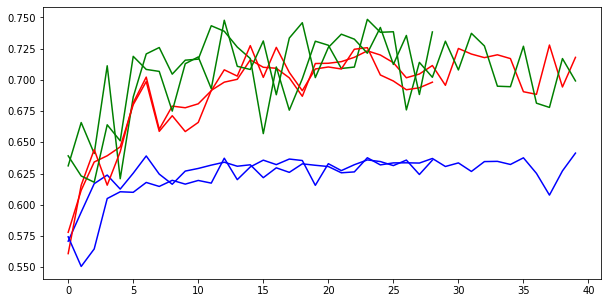

SBM-Isolation


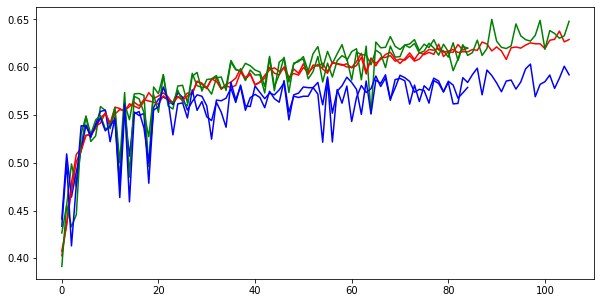

SBM-Environment


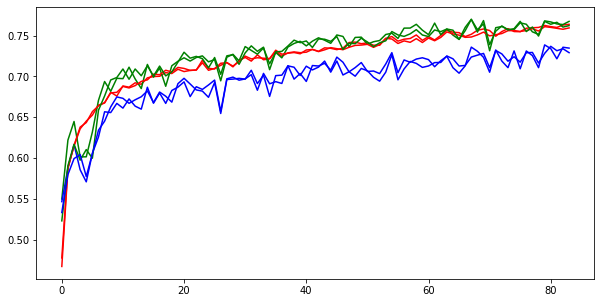

RotatedMNIST


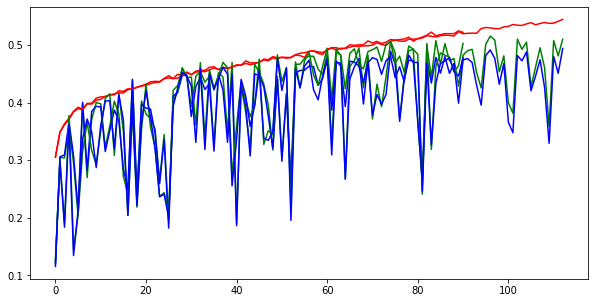

ColoredMNIST


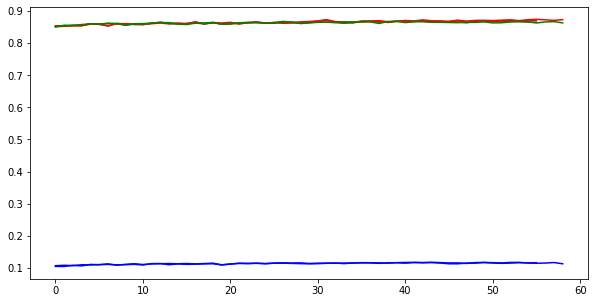

In [21]:
for d in datasets:
    print(d)
    parse('convergence_plot', d=d, a='DANN', m='gin', exps=exps)

Algorithm: ERM, Model: gin
Dataset: ogb-molpcba


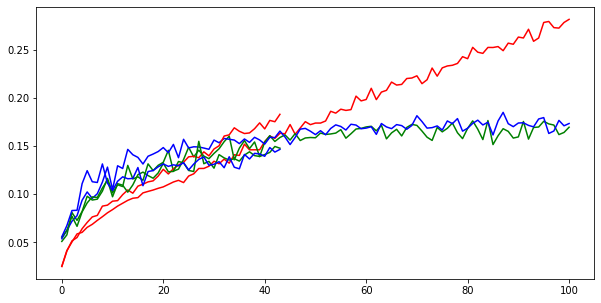

Dataset: ogb-molhiv


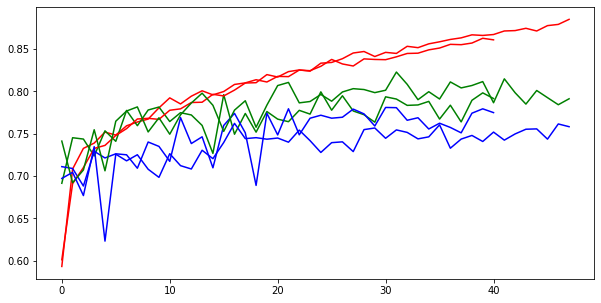

Dataset: ogbg-ppa


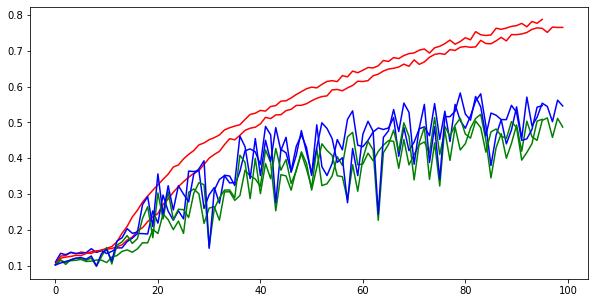

Dataset: UPFD


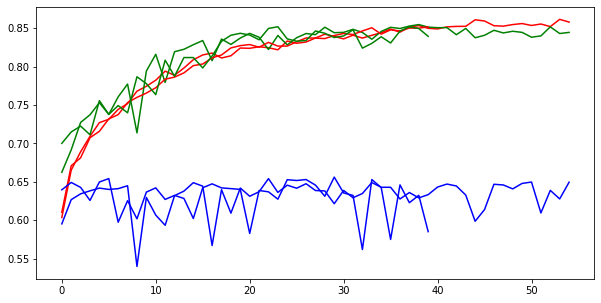

Dataset: SBM-Isolation


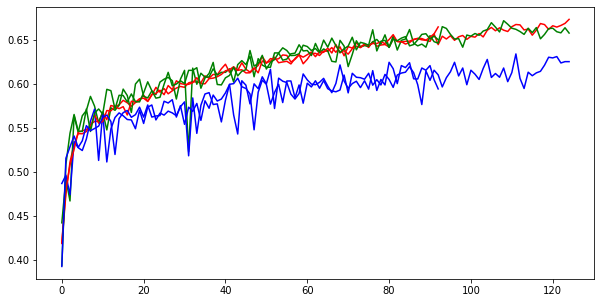

Dataset: SBM-Environment


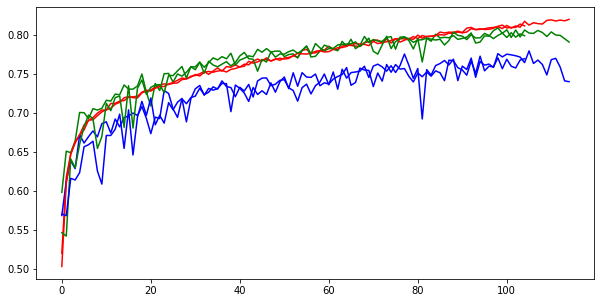

Dataset: RotatedMNIST


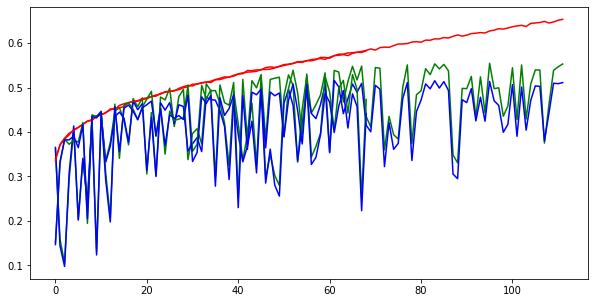

Dataset: ColoredMNIST


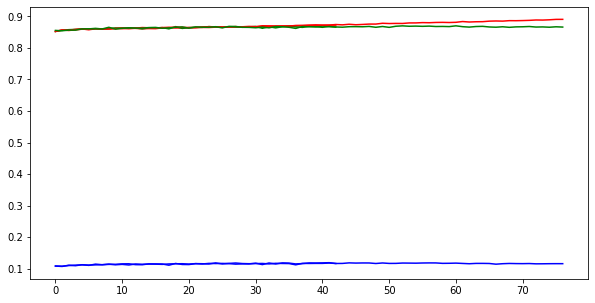

In [10]:
a = algorithms[0]
m = models[0]
exps = [exps[-1]]

print(f'Algorithm: {a}, Model: {m}')
for i, d in enumerate(datasets):
    print(f'Dataset: {d}')
    parse('convergence_plot', d=d, a=a, m=m, exps=exps)

Algorithm: FLAG, Model: gin
Dataset: ogb-molpcba


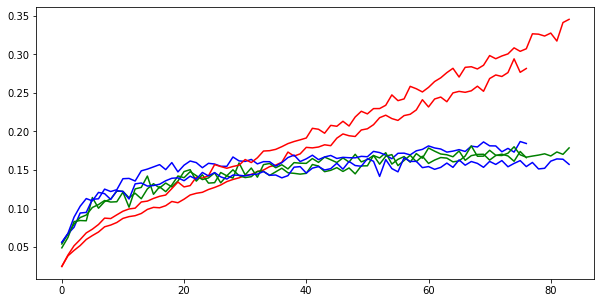

Dataset: ogb-molhiv


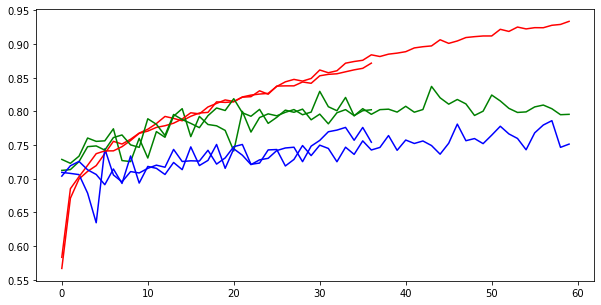

Dataset: ogbg-ppa


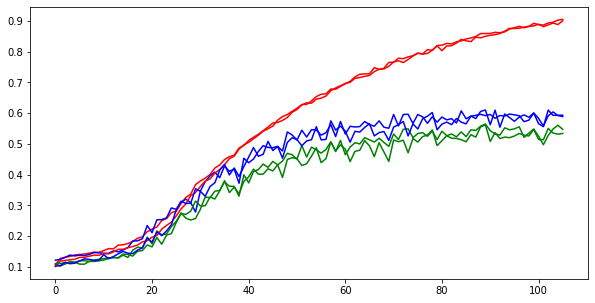

Dataset: UPFD


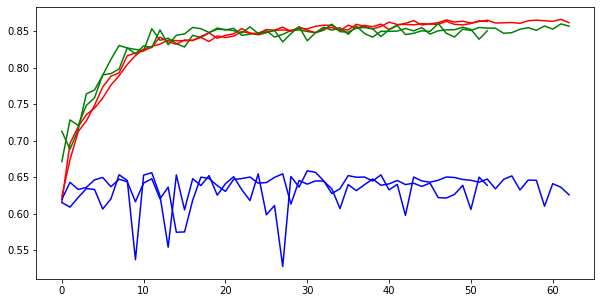

Dataset: SBM-Isolation


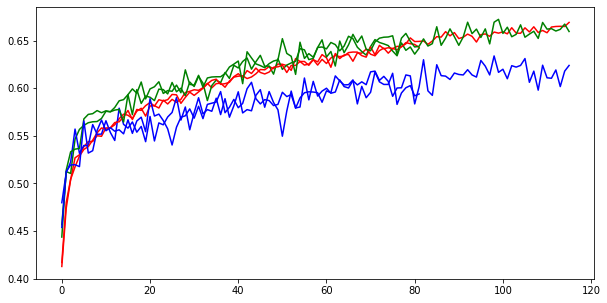

Dataset: SBM-Environment


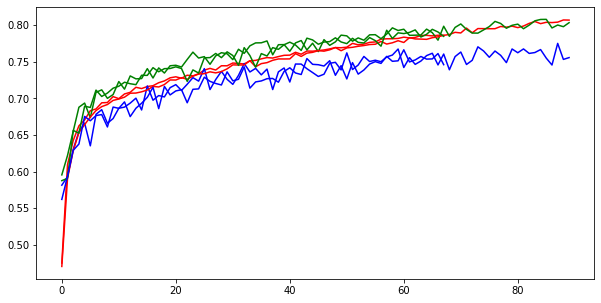

Dataset: RotatedMNIST


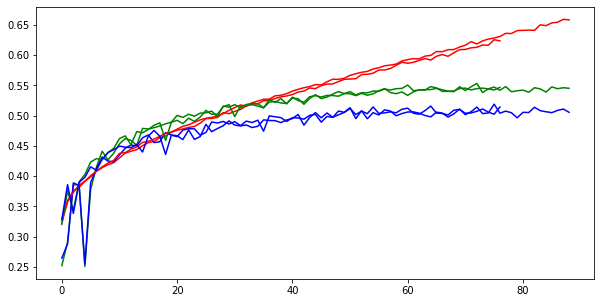

Dataset: ColoredMNIST


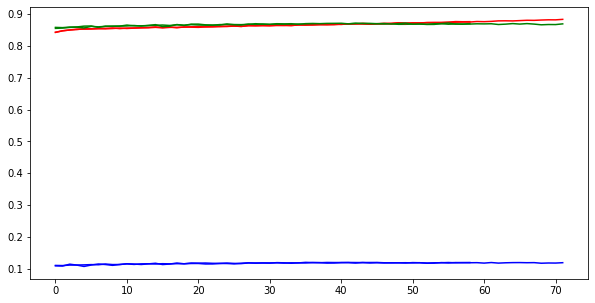

In [11]:
a = algorithms[-1]
m = models[0]
exps = [exps[-1]]

print(f'Algorithm: {a}, Model: {m}')
for i, d in enumerate(datasets):
    print(f'Dataset: {d}')
    parse('convergence_plot', d=d, a=a, m=m, exps=exps)

Algorithm: ERM, Model: cheb
Dataset: ogb-molpcba
Dataset: ogb-molhiv


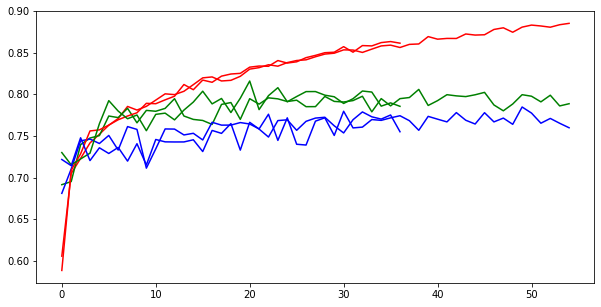

Dataset: ogbg-ppa


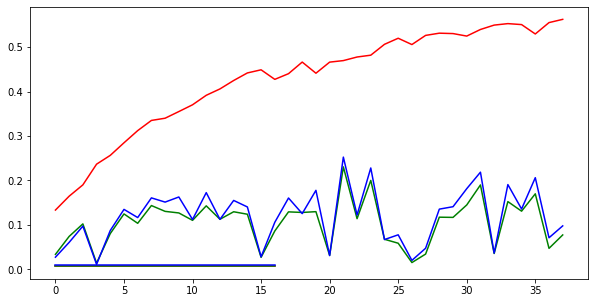

Dataset: UPFD


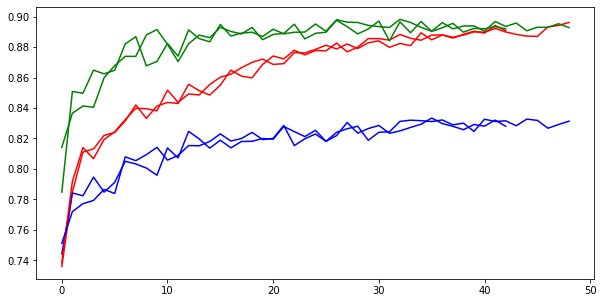

Dataset: SBM-Isolation


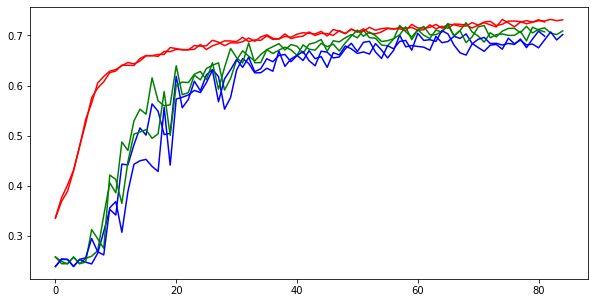

Dataset: SBM-Environment


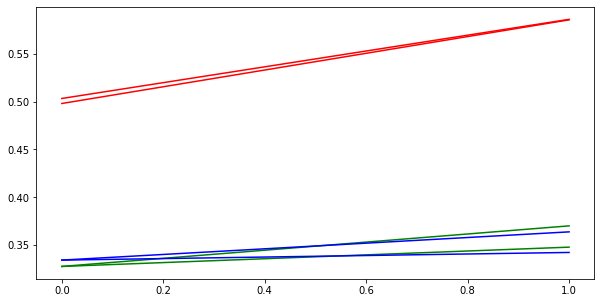

Dataset: RotatedMNIST


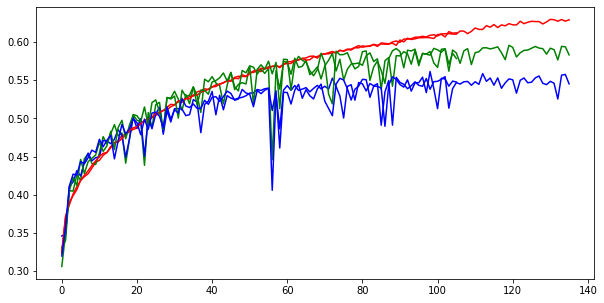

Dataset: ColoredMNIST


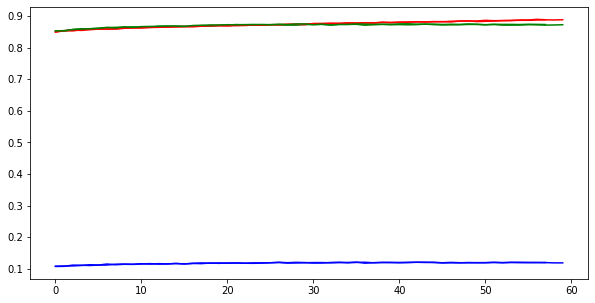

In [12]:
a = algorithms[0]
m = models[-2]
exps = [exps[-1]]

print(f'Algorithm: {a}, Model: {m}')
for i, d in enumerate(datasets):
    print(f'Dataset: {d}')
    parse('convergence_plot', d=d, a=a, m=m, exps=exps)